In [1]:
# %load ../firstcell.txt
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.dpi']=100

import sys
sys.path.append('../')
from read_network import get_network

#### Otra cosa: Roger propuso también normalizar los alimentos en función del valor nutricional. Tomando en cuenta que, en términos de consumo, no es lo mismo un kilo de trigo que un kilo de frijol. Me envió un diccionario de correspondencia peso - valor calórico. Cuéntame si tienes chance de incluir eso. 

In [2]:
with open('../united_names_datasets/REAMDE.txt','r') as readme:
    print(readme.read())

"tradeMatrix_PWG" son los datos de comercio de comida pero con los nombres de los paises en comun de los 4 datasets usado, a saber, GDP, Population, world map y dataset de comercio de comida.

Si alguna vez necesito calcular antifragilidad para cualquier caso, seria bueno usar este dataset para tener nombres homonegeneos y hacer mapas de manera directa


In [8]:
df=pd.read_csv('../united_names_datasets/tradeMatrix_PWG.csv')

In [4]:
df.dtypes

importer     object
exporter     object
Item         object
Element      object
Year          int64
Unit         object
Value       float64
dtype: object

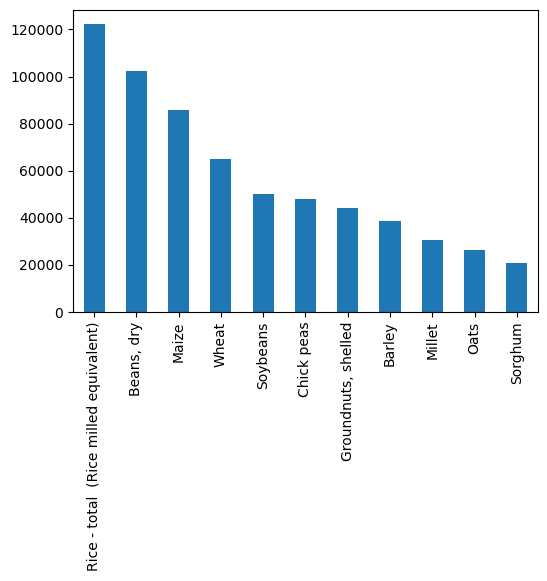

In [5]:
df.Item.value_counts().plot(kind='bar')

In [6]:
dict_100g_kcal = {
'Maize': 356,
'Chick peas' : 358,
'Rice - total  (Rice milled equivalent)' : 360,
'Wheat': 334,
'Beans, dry': 341,
'Groundnuts, shelled' : 567,
'Soybeans': 335,
'Oats': 385,
'Barley': 332,
'Millet': 340,
'Sorghum': 343
}


In [7]:
df['caloric']=df['Item'].map(dict_100g_kcal)

In [8]:
df.head()

,importer,exporter,Item,Element,Year,Unit,Value,caloric
0,Afghanistan,Argentina,Maize,Import Quantity,2017,tonnes,130.0,356
1,Afghanistan,Argentina,Maize,Import Value,2017,1000 US$,68.0,356
2,Afghanistan,Australia,Rice - total (Rice milled equivalent),Import Quantity,2010,tonnes,32.0,360
3,Afghanistan,Australia,Rice - total (Rice milled equivalent),Import Value,2010,1000 US$,21.0,360
4,Afghanistan,Azerbaijan,Rice - total (Rice milled equivalent),Import Quantity,2014,tonnes,16.0,360


In [9]:
def norm_caloric(x,case):
    """Assumes x is a column pandas series (column of dataframe)"""
    
    caloric_value=df[df.Element=='Import Value'].groupby('Year')['caloric'].sum()
    
    if case.lower()=='global_min':
        # multiply x by factors between 0 and 1 that account for the distance each year
        norm_factor=caloric_value.min()/caloric_value
        return x*norm_factor
    
    elif case.lower()=='global_max':
        norm_factor=caloric_value/caloric_value.max()
        return x*norm_factor
    
    elif case=='nrml_max':
        def nrml_max(a):    # Normalize in [0,1]
            return (a - a.min()) / (a.max() - a.min())
        
        norm_factor=nrml(caloric_value)
        return x*norm_factor

    elif case == 'nrml_min':
        def nrml_min(a):
            return (a-a.max())/(a.max()-a.min())
        
        norm_factor=nrml_min(caloric_value)
        return x*norm_factor

In [10]:
def get_norm_df(df,norm_function,name_norm):
    """Return dataframe of antifragility normalized with respect to a certain normalization
    function (norm_function) and name_norm is parameter to specify the normalization name. Examples:
    
    name_norm='distance'
    name_norm='caloric'
    
    """

    def nrml(a):    # Normalize in [0,1]
        return (a - a.min()) / (a.max() - a.min())
    
    # create a dictionary with global amount of trade
        # quantity = Total imports 
        # mean_val = Average price 

    items = df.groupby('Item').groups.keys()
    glob_dict = {}            
    py = df.groupby('Year')  # py = Per Year 
    for year, group in py:
        glob_dict[year] = {}
        for itm in items:
            glob_dict[year][itm] = {}
            glob_dict[year][itm]['quantity'] = group.loc[group['Item']==itm].loc[group['Element']=='Import Quantity']['Value'].sum()
            glob_dict[year][itm]['mean_val'] = group.loc[group['Item']==itm].loc[group['Element']=='Import Value']['Value'].mean()  

    norm_dict = {}    # create a new dictionary for normalizing values
    for itm in items:
        norm_dict[itm] = {}

        for year in range(1986, 2018):
            norm_dict[itm][year] = {}
            norm_dict[itm][year]['qt'] = glob_dict[year][itm]['quantity']
            norm_dict[itm][year]['vl'] = glob_dict[year][itm]['mean_val']

    for itm in items:  # add normalized values to global yearly dictionary 
        dfa = pd.DataFrame(norm_dict[itm]).transpose()
        dfa['nqt'] = nrml(dfa['qt'])
        dfa['nvl'] = nrml(dfa['vl'])
        for year in range(1986, 2018):
            glob_dict[year][itm]['qnt'] = dfa.loc[year]['nqt']
            glob_dict[year][itm]['val'] = dfa.loc[year]['nvl']
            
    
    for year in range(1987, 2018):  #  Calculate differences of trade values on consecutive years 
        for itm in items:
            glob_dict[year][itm]['delta_qt'] = np.abs(glob_dict[year][itm]['qnt'] - glob_dict[year-1][itm]['qnt'])
            glob_dict[year][itm]['delta_pr'] = np.abs(glob_dict[year][itm]['val'] - glob_dict[year-1][itm]['val'])


    norm_dict2 = {}    # create a dictionary for normalizing delta values
    for itm in items:
        norm_dict2[itm] = {}
        for year in range(1987, 2018):
            norm_dict2[itm][year] = {}
            norm_dict2[itm][year]['delta_pr'] = glob_dict[year][itm]['delta_pr']
            norm_dict2[itm][year]['delta_qt'] = glob_dict[year][itm]['delta_qt']


    for itm in items:  # add normalized delta values to global yearly dictionary 
        dfa = pd.DataFrame(norm_dict2[itm]).transpose()

        dfa[f'{name_norm}_delta_qt_n'] = norm_caloric(dfa['delta_qt'],case='global_min')
        dfa[f'{name_norm}_delta_pr_n'] = norm_caloric(dfa['delta_pr'],case='global_min')

        for year in range(1987, 2018):

            glob_dict[year][itm][f'{name_norm}_pertb_pr'] = dfa.loc[year][f'{name_norm}_delta_pr_n']
            glob_dict[year][itm][f'{name_norm}_pertb_qt'] = dfa.loc[year][f'{name_norm}_delta_qt_n']
            
    
    for year in range(1987, 2018):  # take yearly mean of perturbation over Item list ...
        glob_dict[year][f'{name_norm}_PERTB_pr'] = pd.DataFrame(glob_dict[year]).transpose()[f'{name_norm}_pertb_pr'].mean()
        glob_dict[year][f'{name_norm}_PERTB_qt'] = pd.DataFrame(glob_dict[year]).transpose()[f'{name_norm}_pertb_qt'].mean()


    DF = pd.DataFrame(glob_dict).transpose()
    DF[f'{name_norm}_perturb_pr'] = nrml(DF[f'{name_norm}_PERTB_pr'])  # ... and Normalize them 
    DF[f'{name_norm}_perturb_qt'] = nrml(DF[f'{name_norm}_PERTB_qt'])

    for year in range(1987, 2018):             # Add normalized perturbations values to global dictionary 
        glob_dict[year][f'{name_norm}_pertN_pr'] = DF.loc[year][f'{name_norm}_perturb_pr']
        glob_dict[year][f'{name_norm}_pertN_qt'] = DF.loc[year][f'{name_norm}_perturb_qt']
        

    dict_perts = {}    #   Create dictionary and DataFrame for perturbations 
    for year in range(1987, 2018):
        dict_perts[year] = {}
        for x in [f'{name_norm}_pertN_pr',f'{name_norm}_pertN_qt']:
            dict_perts[year][x] = glob_dict[year][x]
        for itm in items:
            for y in [f'{name_norm}_pertb_pr', f'{name_norm}_pertb_qt']:
                dict_perts[year][itm+y[-3:]] = glob_dict[year][itm][y]


    dfperts = pd.DataFrame(dict_perts).transpose()   
    
    #READ NETWORK
    
    lg=get_network()

    #  create a dictionary with amount of trade per country
        # quantity = Total imports 
        # mean_val = Average price     

    items = df.groupby('Item').groups.keys()
    dict_country = {}            
    pc = df.groupby('Year')  # pc = Per Country 

    for name, group in df.groupby('importer'):
        dict_country[name] = {}

    for name, group in df.groupby('exporter'):
        if name not in dict_country.keys():
            dict_country[name] = {}

    year = int(1986)
    for G in lg:
        for x in G.nodes():
            dict_country[x][year] = {}
            for y in G.out_edges(x):        
                for key, val in G[y[0]][y[1]].items():
                    for k, v in val.items():
                        dict_country[x][year]['exp_'+key+'_'+k] = v
            for y in G.in_edges(x):
                for key, val in G[y[0]][y[1]].items():
                    for k, v in val.items():
                        dict_country[x][year]['imp_'+key+'_'+k] = v
        year += 1
        
    def nrml_(a):   # Normalize in [-1,1]
        return 2*(a - a.min()) / (a.max() - a.min()) -1
    

    for key, val in dict_country.items():
        xxx = pd.DataFrame(val).transpose()
        for col in xxx.columns:
            xxx[col] = nrml(xxx[col])
            xxx['dlt_'+col] = xxx[col] - xxx[col].shift(1)
            xxx['dlt_'+col] = nrml_(xxx['dlt_'+col])
        for year in range(1987, 2018):
            try:
                dict_country[key][year]['dlt_in_pr'] = xxx.drop([xc for xc in xxx.columns if 'dlt_imp_' != xc[:8] or '_value' not in xc ], axis=1).transpose()[year].mean()
                dict_country[key][year]['dlt_in_vl'] = xxx.drop([xc for xc in xxx.columns if 'dlt_imp_' != xc[:8] or '_weight' not in xc ], axis=1).transpose()[year].mean()
                dict_country[key][year]['dlt_ex_pr'] = xxx.drop([xc for xc in xxx.columns if 'dlt_exp_' != xc[:8] or '_value' not in xc ], axis=1).transpose()[year].mean()
                dict_country[key][year]['dlt_ex_vl'] = xxx.drop([xc for xc in xxx.columns if 'dlt_exp_' != xc[:8] or '_weight' not in xc ], axis=1).transpose()[year].mean()
            except: 
                pass
            

    dictotal = {} 
    i = 0
    j = 0
    lp = []
    for country in dict_country.keys():
        dictotal[country] = {}
        for year in dict_perts.keys():
            dictotal[country][year] = {}
            try:
                dictotal[country][year][f'{name_norm}_af_in_pr'] = -1*dict_country[country][year]['dlt_in_pr'] * dict_perts[year][f'{name_norm}_pertN_pr']
                dictotal[country][year][f'{name_norm}_af_in_vl'] = -1*dict_country[country][year]['dlt_in_vl'] * dict_perts[year][f'{name_norm}_pertN_qt']
                dictotal[country][year][f'{name_norm}_af_ex_pr'] = dict_country[country][year]['dlt_ex_pr'] * dict_perts[year][f'{name_norm}_pertN_pr']
                dictotal[country][year][f'{name_norm}_af_ex_vl'] = dict_country[country][year]['dlt_ex_vl'] * dict_perts[year][f'{name_norm}_pertN_qt']
                dictotal[country][year][f'{name_norm}_af_in_pr2'] = -1*dict_country[country][year]['dlt_in_pr'] * (dict_perts[year][f'{name_norm}_pertN_pr'] + dict_perts[year][f'{name_norm}_pertN_qt'])/2
                dictotal[country][year][f'{name_norm}_af_in_vl2'] = -1*dict_country[country][year]['dlt_in_vl'] * (dict_perts[year][f'{name_norm}_pertN_pr'] + dict_perts[year][f'{name_norm}_pertN_qt'])/2
                dictotal[country][year][f'{name_norm}_af_ex_pr2'] = dict_country[country][year]['dlt_ex_pr'] * (dict_perts[year][f'{name_norm}_pertN_pr'] + dict_perts[year][f'{name_norm}_pertN_qt'])/2
                dictotal[country][year][f'{name_norm}_af_ex_vl2'] = dict_country[country][year]['dlt_ex_vl'] * (dict_perts[year][f'{name_norm}_pertN_pr'] + dict_perts[year][f'{name_norm}_pertN_qt'])/2

            except:
                j += 1
                lp += [country]
            i += 1
    print('total loops = ',i, 'total exceptions = ',j)
    

    tk = {}
    for key, val in dictotal.items():
        tk[key] = {}
        ddff = pd.DataFrame(val).transpose()
        for col in ddff.columns:
            tk[key][col] = ddff[col].mean()
    
    afs = pd.DataFrame(tk).transpose()
    
    return afs

In [11]:
af_caloric=get_norm_df(df,norm_caloric,'caloric')

total loops =  7502 total exceptions =  1925


In [45]:
# af_caloric.to_csv('caloric_af_percountry.csv')

In [4]:
af_caloric=pd.read_csv('caloric_af_percountry.csv',index_col=0)

In [6]:
tk=af_caloric.T.to_dict()

In [9]:
grc = df.groupby('importer')
for name, group in grc: 
    qt = group.loc[group['Element'] == 'Import Quantity']
    tk[name]['tot_imp_qt'] = np.sum(qt['Value'])
    vl = group.loc[group['Element'] == 'Import Value']
    tk[name]['tot_imp_vl'] = np.sum(vl['Value'])

grc = df.groupby('exporter')
for name, group in grc: 
    qt = group.loc[group['Element'] == 'Import Quantity']
    tk[name]['tot_exp_qt'] = np.sum(qt['Value'])
    vl = group.loc[group['Element'] == 'Import Value']
    tk[name]['tot_exp_vl'] = np.sum(vl['Value'])

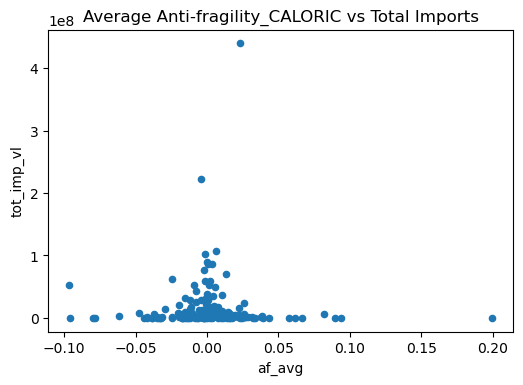

In [10]:
ttk = pd.DataFrame(tk).transpose().drop(['tot_imp_qt', 'tot_imp_vl', 'tot_exp_qt', 'tot_exp_vl'], axis=1)
ttk = ttk[['caloric_af_in_pr', 'caloric_af_in_vl', 'caloric_af_ex_pr', 'caloric_af_ex_vl',
    'caloric_af_in_pr2', 'caloric_af_in_vl2', 'caloric_af_ex_pr2', 'caloric_af_ex_vl2']]

tttk = pd.DataFrame(tk).transpose()
tttk['af_avg'] = ttk.transpose().describe().transpose()['mean']

tttk.plot(kind='scatter', y='tot_imp_vl', x='af_avg', figsize=(6,4), title="Average Anti-fragility_CALORIC vs Total Imports")


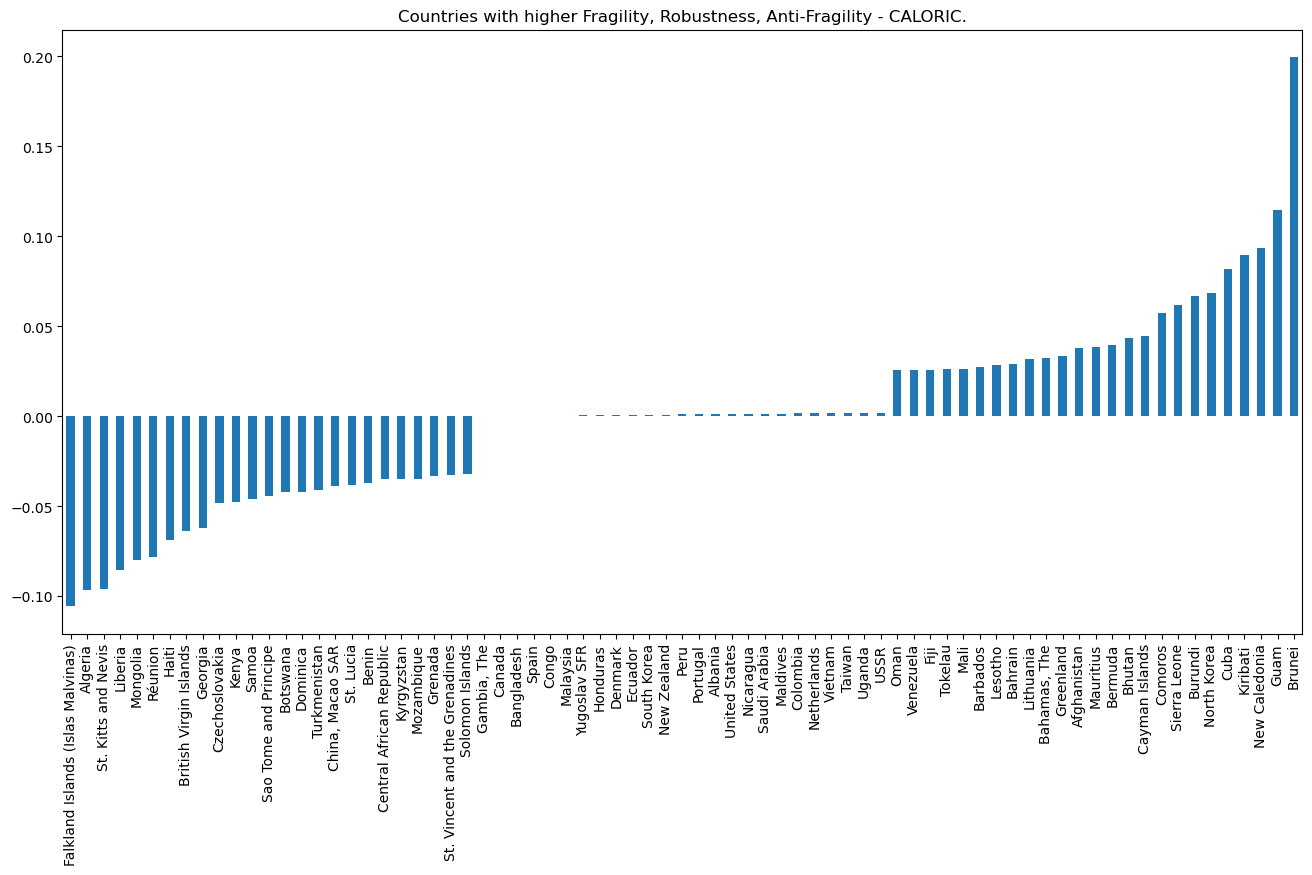

In [11]:
ttk.drop([col for col in ttk.columns if 'in' not in col], axis=1)
top = ttk.transpose().describe().transpose()['mean'].sort_values().head(int(25)) #.plot(kind='bar', figsize=(16,8))
bot = ttk.transpose().describe().transpose()['mean'].dropna().sort_values().tail(int(25)) #.plot(kind='bar', figsize=(16,8))
med = ttk.transpose().describe().transpose()['mean'].abs().sort_values().head(int(25))#.plot(kind='bar', figsize=(16,8))
top.append(med.append(bot)).plot(kind='bar', figsize=(16,8), title="Countries with higher Fragility, Robustness, Anti-Fragility - CALORIC.")